# CAPSTONE PROJECT

## Connect Colab to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IMPORT PACKAGES

In [ ]:
import pandas as pd
import seaborn as sns
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
def detail(df):
  print(f"Shape of data: {df.shape}")
  print(f"Number of missing values in data: {df.isnull().sum().sum()}")
def missing(df):
  miss = df.isnull().sum()
  return miss
def unique(df):
  unik = df.apply(lambda x: len(x.unique()))
  return unik

## Connect SQLite to Python

In [ ]:
conn = sqlite3.connect("/content/drive/MyDrive/Narasio/Capstone_Project/6. New York Bus Rides/New York Bus Rides.db")
cur = conn.cursor()

## Data Preparation Using SQL

In [ ]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('bookings',), ('segments',), ('searches',)]


In [ ]:
df_total1 = pd.read_sql_query("""SELECT  a.*, b.*, c.*
FROM    segments a
        INNER JOIN searches b
            ON a.user_id = b.user_id
        LEFT JOIN bookings c
            ON b.session_id = c.search_session_id""", conn)

In [ ]:
df_total1.head()

,user_id,yr_wk,new_segment_tag,session_id,search_id,user_id,search_city,search_time,num_of_results,is_result,median_pickup_walk_time,median_dropoff_walk_time,median_bus_travel_time,high_demand_val,user_device_os,user_device_app_version,search_session_id,booking_id,booking_timestamp
0,5cfe072e5612de0019c6f4b5,2019-24,New,7c80fae5-210c-4ace-a5df-5221d6a5a008,6d2b4ed4-88bf-47bb-95fd-0bbecd824775,5cfe072e5612de0019c6f4b5,New York,2020-02-24 13:36:19.625 UTC,4,1,600.0,1440.0,3336.0,0,android,291.0,7c80fae5-210c-4ace-a5df-5221d6a5a008,5e53b5664dc0e1001a423476,2020-02-24 13:37:10.395 UTC
1,5cfe072e5612de0019c6f4b5,2019-29,Inactive,7c80fae5-210c-4ace-a5df-5221d6a5a008,6d2b4ed4-88bf-47bb-95fd-0bbecd824775,5cfe072e5612de0019c6f4b5,New York,2020-02-24 13:36:19.625 UTC,4,1,600.0,1440.0,3336.0,0,android,291.0,7c80fae5-210c-4ace-a5df-5221d6a5a008,5e53b5664dc0e1001a423476,2020-02-24 13:37:10.395 UTC
2,5cfe072e5612de0019c6f4b5,2019-39,Inactive,7c80fae5-210c-4ace-a5df-5221d6a5a008,6d2b4ed4-88bf-47bb-95fd-0bbecd824775,5cfe072e5612de0019c6f4b5,New York,2020-02-24 13:36:19.625 UTC,4,1,600.0,1440.0,3336.0,0,android,291.0,7c80fae5-210c-4ace-a5df-5221d6a5a008,5e53b5664dc0e1001a423476,2020-02-24 13:37:10.395 UTC
3,5cfe072e5612de0019c6f4b5,2019-26,Retained,7c80fae5-210c-4ace-a5df-5221d6a5a008,6d2b4ed4-88bf-47bb-95fd-0bbecd824775,5cfe072e5612de0019c6f4b5,New York,2020-02-24 13:36:19.625 UTC,4,1,600.0,1440.0,3336.0,0,android,291.0,7c80fae5-210c-4ace-a5df-5221d6a5a008,5e53b5664dc0e1001a423476,2020-02-24 13:37:10.395 UTC
4,5cfe072e5612de0019c6f4b5,2019-47,Retained,7c80fae5-210c-4ace-a5df-5221d6a5a008,6d2b4ed4-88bf-47bb-95fd-0bbecd824775,5cfe072e5612de0019c6f4b5,New York,2020-02-24 13:36:19.625 UTC,4,1,600.0,1440.0,3336.0,0,android,291.0,7c80fae5-210c-4ace-a5df-5221d6a5a008,5e53b5664dc0e1001a423476,2020-02-24 13:37:10.395 UTC


In [ ]:
detail(df_total1)

Shape of data: (161469, 19)
Number of missing values in data: 331620


In [ ]:
unique(df_total1)

user_id                     6331
yr_wk                         42
new_segment_tag                4
session_id                  7000
search_id                   7000
user_id                     6331
search_city                    1
search_time                 7000
num_of_results                58
is_result                      1
median_pickup_walk_time      310
median_dropoff_walk_time     297
median_bus_travel_time      5160
high_demand_val               11
user_device_os                 4
user_device_app_version       76
search_session_id           2146
booking_id                  2151
booking_timestamp           2141
dtype: int64

## PROBLEM STATEMENT



1.   Pada jam berapakah jumlah search mengalami kenaikan/penurunan ?
2.   Pada jam berapakah jumlah booking mengalami kenaikan/penurunan ?
3. Segmentasi user apa yang paling mendominasi?
4. Device apa yang paling banyak digunakan oleh user?



## DATA CLEANSING

In [ ]:
missing(df_total1)

user_id                          0
yr_wk                            0
new_segment_tag                  0
session_id                       0
search_id                        0
user_id                          0
search_city                      0
search_time                      0
num_of_results                   0
is_result                        0
median_pickup_walk_time       1037
median_dropoff_walk_time      1037
median_bus_travel_time           0
high_demand_val                  0
user_device_os                   9
user_device_app_version          9
search_session_id           109744
booking_id                  109744
booking_timestamp           110040
dtype: int64

In [ ]:
df_total1.user_device_os.unique()

array(['android', 'ios', None, 'iOS'], dtype=object)

* Drop missing value pada 
> 1.   median_pickup_walk_time
> 2.   median_dropoff_walk_time
* Drop salah satu kolom user_id
* Drop kolom search_session_id karena sama dengan kolom session_id
* Isi missing value pada user_device_os menggunakan mode
* Rename user_device_os

Untuk nilai dari tabel booking saya biarkan karena mengandung informasi penting tentang data pemesanan dan apabila missing value pada kolom tersebut dihapus bisa mengurangi banyak sekali data

In [ ]:
# drop missing value pada median_pickup_walk_time dan median_dropoff_walk_time
df_total2 = df_total1.dropna(subset=['median_pickup_walk_time', 'median_dropoff_walk_time'])
# drop kolom search_session_id
df_total2 = df_total1.drop('search_session_id', axis=1)
# drop salah satu kolom user_id
df_total2 = df_total1.loc[:,~df_total1.columns.duplicated()]

# fill missing value pada user_device_os
df_total2['user_device_os'] = df_total2['user_device_os'].fillna(df_total2['user_device_os'].mode().iloc[0])
df_total2['user_device_app_version'] = df_total2['user_device_app_version'].fillna(df_total2['user_device_app_version'].mode().iloc[0])
# rename kolom user_device_os
map_device = {'android': 'android', 'ios': 'iOS', 'iOS': 'iOS'}
df_total2['user_device_os'] = df_total2['user_device_os'].apply(lambda x: map_device[x])
detail(df_total2)

Shape of data: (161469, 18)
Number of missing values in data: 331602


In [ ]:
missing(df_total2)

user_id                          0
yr_wk                            0
new_segment_tag                  0
session_id                       0
search_id                        0
search_city                      0
search_time                      0
num_of_results                   0
is_result                        0
median_pickup_walk_time       1037
median_dropoff_walk_time      1037
median_bus_travel_time           0
high_demand_val                  0
user_device_os                   0
user_device_app_version          0
search_session_id           109744
booking_id                  109744
booking_timestamp           110040
dtype: int64

Mengubah kolom datetime

In [ ]:
df_total2['search_time'] = pd.to_datetime(df_total2['search_time'])
df_total2['booking_timestamp'] = pd.to_datetime(df_total2['booking_timestamp'])
df_total2['hour_search'] = df_total2.search_time.dt.hour
df_total2['hour_books'] = df_total2.booking_timestamp.dt.hour
df_total2['day_search'] = df_total2['search_time'].apply(lambda x: x.strftime('%A'))
df_total2['day_books'] = df_total2['booking_timestamp'].apply(lambda x: x.strftime('%A'))

## EXPLORATORY DATA

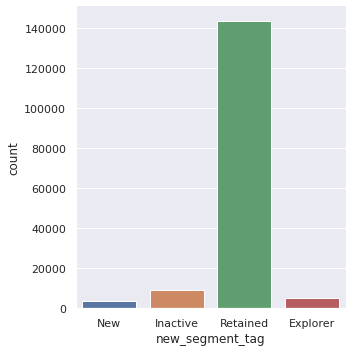

In [ ]:
sns.catplot(x="new_segment_tag", kind="count",
            data=df_total2)

Jumlah user paling banyak yaitu user retained.

In [ ]:
a = pd.DataFrame(df_total2.groupby([pd.Grouper(key='search_time', freq='h'), 'hour_search', 'day_search'])[['search_id']].count())
hour = []
day = []
for value in a.index.get_level_values(1):
  hour.append(value)
for value in a.index.get_level_values(2):
  day.append(value)
a['hour'] = hour
a['day'] = day
a

,,,search_id,hour,day
search_time,hour_search,day_search,,,
2019-10-14 03:00:00+00:00,3,Monday,12,3,Monday
2019-10-14 04:00:00+00:00,4,Monday,32,4,Monday
2019-10-14 07:00:00+00:00,7,Monday,12,7,Monday
2019-10-14 08:00:00+00:00,8,Monday,82,8,Monday
2019-10-14 09:00:00+00:00,9,Monday,67,9,Monday
...,...,...,...,...,...
2020-03-22 15:00:00+00:00,15,Sunday,29,15,Sunday
2020-03-22 17:00:00+00:00,17,Sunday,61,17,Sunday
2020-03-22 20:00:00+00:00,20,Sunday,4,20,Sunday


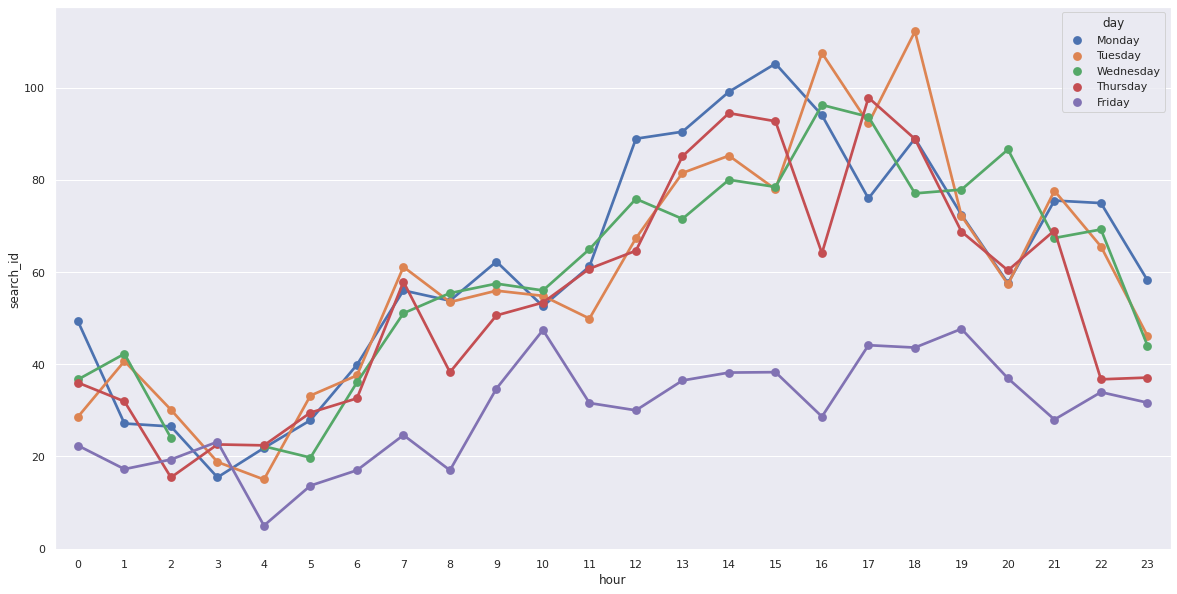

In [ ]:
sns.set_theme(style="darkgrid")
hue_ords = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
fig, ax = plt.subplots(figsize=(20, 10))
sns.pointplot(data=a, x='hour', y='search_id', hue='day', hue_order=hue_ords, ci=None, ax=ax)

Dari grafik di atas terlihat bahwa terdapat pola antara jam dan banyaknya search. Dalam hari kerja mulai jam 5 terjadi kenaikan search. Mulai jam 4 sore jumlah search sudah mulai menurun. Hal ini bisa dilihat bahwa pada jam 5 orang orang sudah mulai beraktivitas seperti berangkat kerja, sehingga terjadi lonjakan search. Untuk jam 4 orang orang sudah mulai pulang dari pekerjaannya sehingga sudah tidak ada lagi user yang melakukan searching.

In [ ]:
b = df_total2.groupby([pd.Grouper(key='booking_timestamp', freq='H'), 'hour_books', 'day_books', 'new_segment_tag']).agg(booking_count=('booking_id', 'count'),
          #segment_user=('new_segment_tag', 'nunique'),
         median_pickup_walk_time=('median_pickup_walk_time','mean'),
         median_dropoff_walk_time=('median_dropoff_walk_time','mean'),
        median_bus_travel_time=('median_bus_travel_time', 'mean'))
hour = []
day = []
user = []
for value in b.index.get_level_values(1):
  hour.append(value)
for value in b.index.get_level_values(2):
  day.append(value)
for value in b.index.get_level_values(3):
  user.append(value)
b['hour'] = hour
b['day'] = day
b['user'] = user
b

booking_count  ...      user
booking_timestamp         hour_books day_books new_segment_tag                 ...          
2019-10-14 08:00:00+00:00 8.0        Monday    Retained                    82  ...  Retained
2019-10-14 09:00:00+00:00 9.0        Monday    Explorer                     1  ...  Explorer
                                               New                          1  ...       New
2019-10-14 10:00:00+00:00 10.0       Monday    Retained                    30  ...  Retained
2019-10-14 14:00:00+00:00 14.0       Monday    Explorer                     3  ...  Explorer
...                                                                       ...  ...       ...
2020-03-22 17:00:00+00:00 17.0       Sunday    Inactive                     3  ...  Inactive
                                               New                          1  ...       New
                                               Retained                    15  ...  Retained
2020-03-22 20:00:00+00:00 20.0       Sunday    New                          1  ...       New
                                               Retained                     3  ...  Retained

[3424 rows x 7 columns]

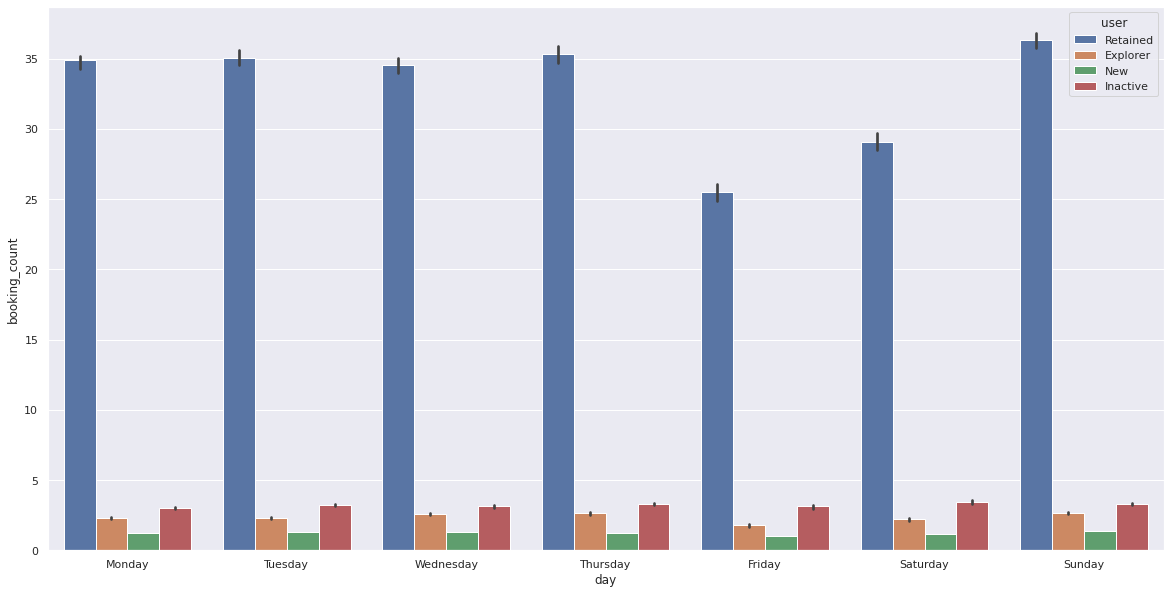

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=b, x='day', y='booking_count', hue='user', ci=25, ax=ax)

Pemesanan didominasi oleh user retained. User selain retained tetap melakukan pemesanan, namun jumlah dari user tersebut sangatlah kecil.

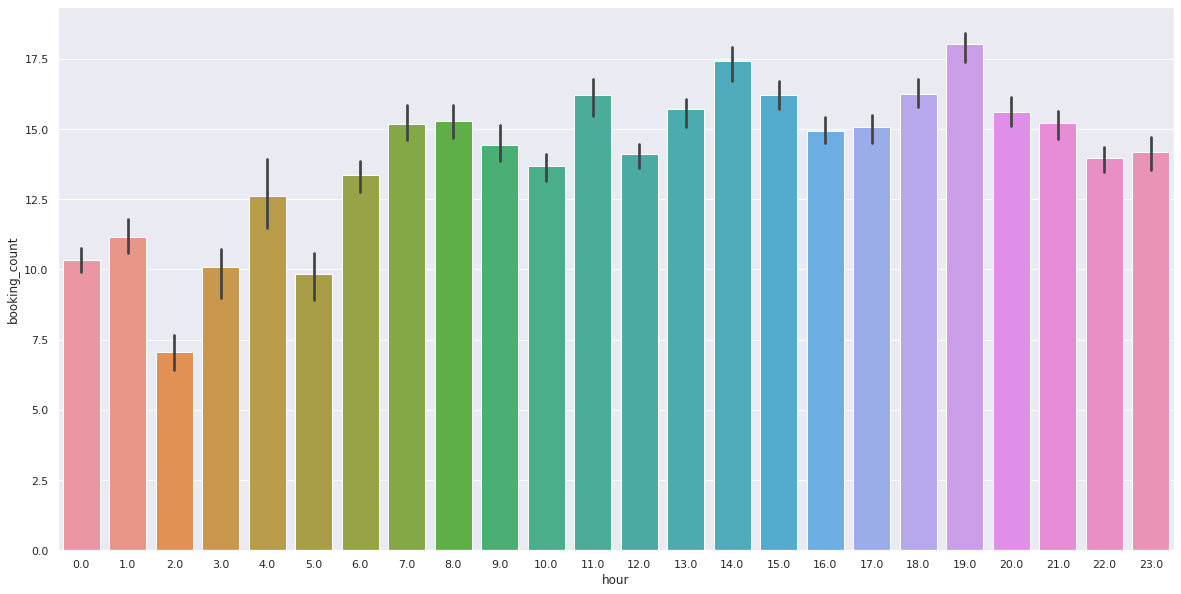

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=b, x='hour', y='booking_count', ci=25, ax=ax)

Jumlah pemesanan bus ride mulai meningkat pada jam 4 pagi. Jumlah pemesanan bus ride mulai menurun pada jam 7 malam.

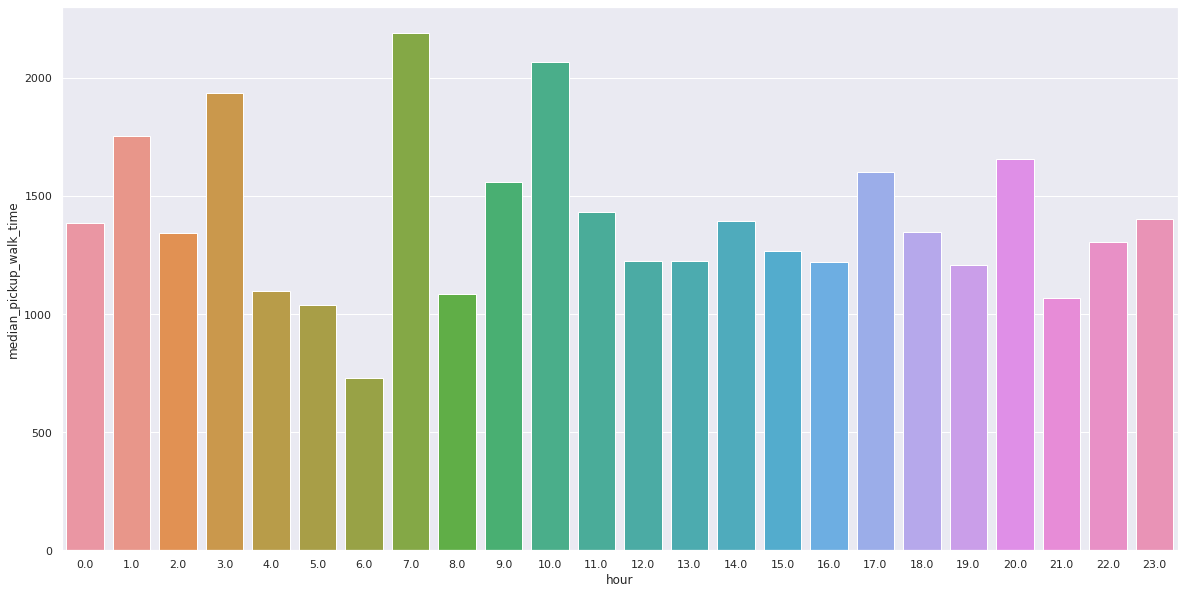

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=b, x='hour', y='median_pickup_walk_time', ci=None, ax=ax)

Grafik di atas menunjukkan nilai rata rata median_pickup_walk_time terhadap jam. Pada pagi hari tepatnya jam 6 pagi nilai rata rata pickup time mulai naik sampai jam 7. Hal ini dikarenakan pada jam tersebut orang orang sudah mulai berangkat kerja, sehingga waktu yang dibutuhkan juga bertambah seiringnya user.

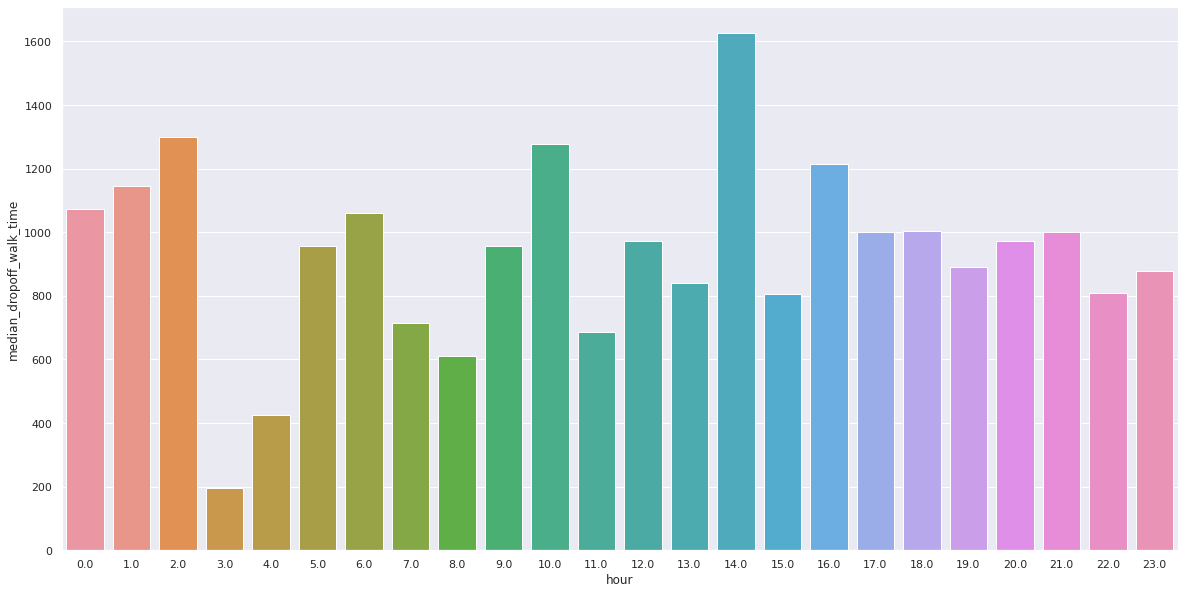

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=b, x='hour', y='median_dropoff_walk_time', ci=None, ax=ax)

Perkiraan waktu yang dibutuhkan pelanggan untuk berjalan kaki dari stasiun bus tujuan yang diinginkan pada grafik di atas tidak memiliki pola tertentu dikarenakan hal ini tidak memiliki keterkaitan antara jam sibuk atau tidak. 



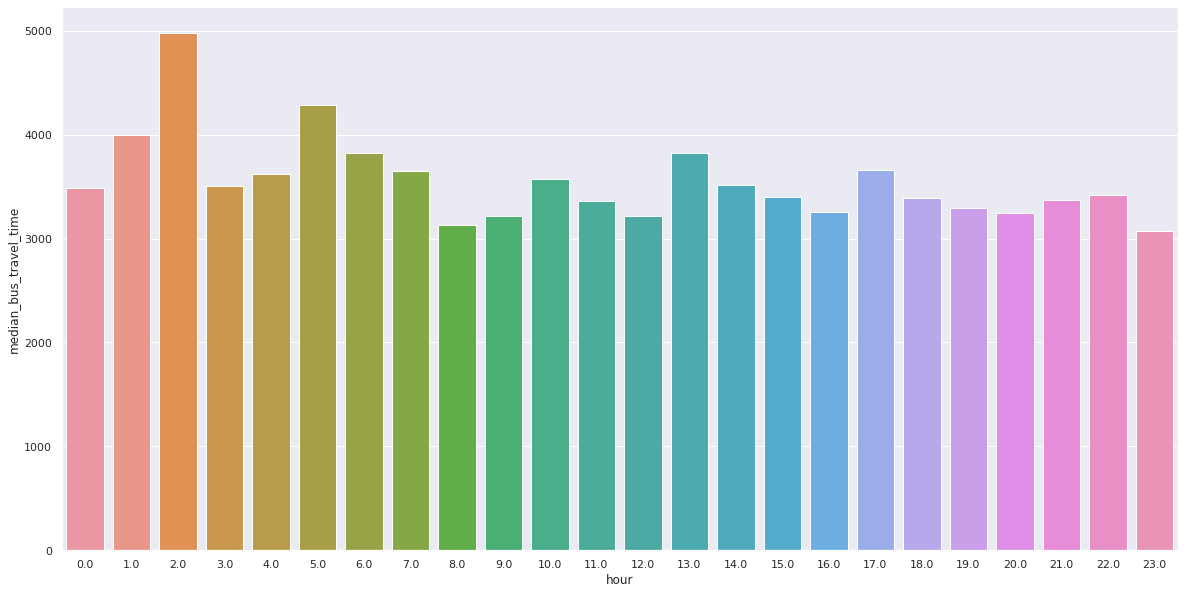

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=b, x='hour', y='median_bus_travel_time', ci=None, ax=ax)

Perkiraan waktu tempuh bus dalam perjalanan juga tidak memiliki pola tertentu. Hal ini berarti tidak ada suatu delay dalam perjalanan yang bisa menambah waktu tempuh bus.

In [ ]:
c = df_total2.groupby([pd.Grouper(key='search_time', freq='H'), 'hour_search', 'day_search', 'new_segment_tag']).agg(search_count=('search_id', 'count'),
          high_demand=('high_demand_val', 'sum'),
         median_pickup_walk_time=('median_pickup_walk_time','mean'),
         median_dropoff_walk_time=('median_dropoff_walk_time','mean'),
        median_bus_travel_time=('median_bus_travel_time', 'mean'))
hour = []
day = []
user = []
for value in c.index.get_level_values(1):
  hour.append(value)
for value in c.index.get_level_values(2):
  day.append(value)
for value in c.index.get_level_values(3):
  user.append(value) 
c['hour'] = hour
c['day'] = day
c['user'] = user
c

search_count  ...      user
search_time               hour_search day_search new_segment_tag                ...          
2019-10-14 03:00:00+00:00 3           Monday     Explorer                    3  ...  Explorer
                                                 New                         1  ...       New
                                                 Retained                    8  ...  Retained
2019-10-14 04:00:00+00:00 4           Monday     Inactive                    8  ...  Inactive
                                                 Retained                   24  ...  Retained
...                                                                        ...  ...       ...
2020-03-22 20:00:00+00:00 20          Sunday     Retained                    3  ...  Retained
2020-03-22 22:00:00+00:00 22          Sunday     New                         1  ...       New
                                                 Retained                    9  ...  Retained
2020-03-22 23:00:00+00:00 23          Sunday     Inactive                    3  ...  Inactive
                                                 Retained                   14  ...  Retained

[7826 rows x 8 columns]

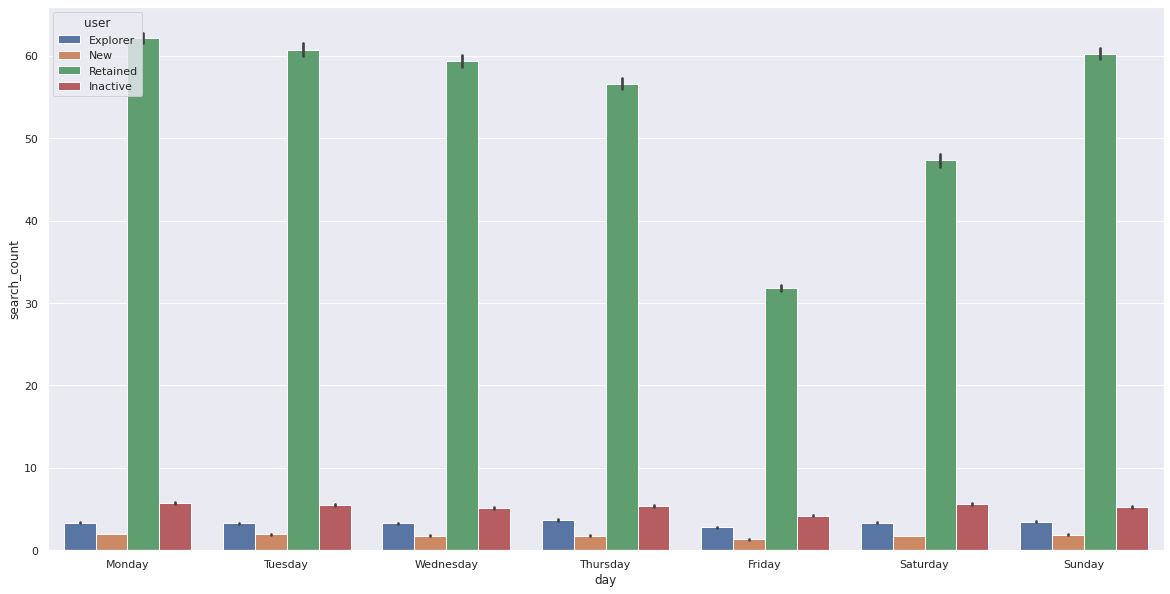

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=c, x='day', y='search_count', hue='user', ci=25, ax=ax)

Sama halnya dengan pemesanan, pencarian didominasi oleh user retained dan user lainnya hanya sedikit saja.

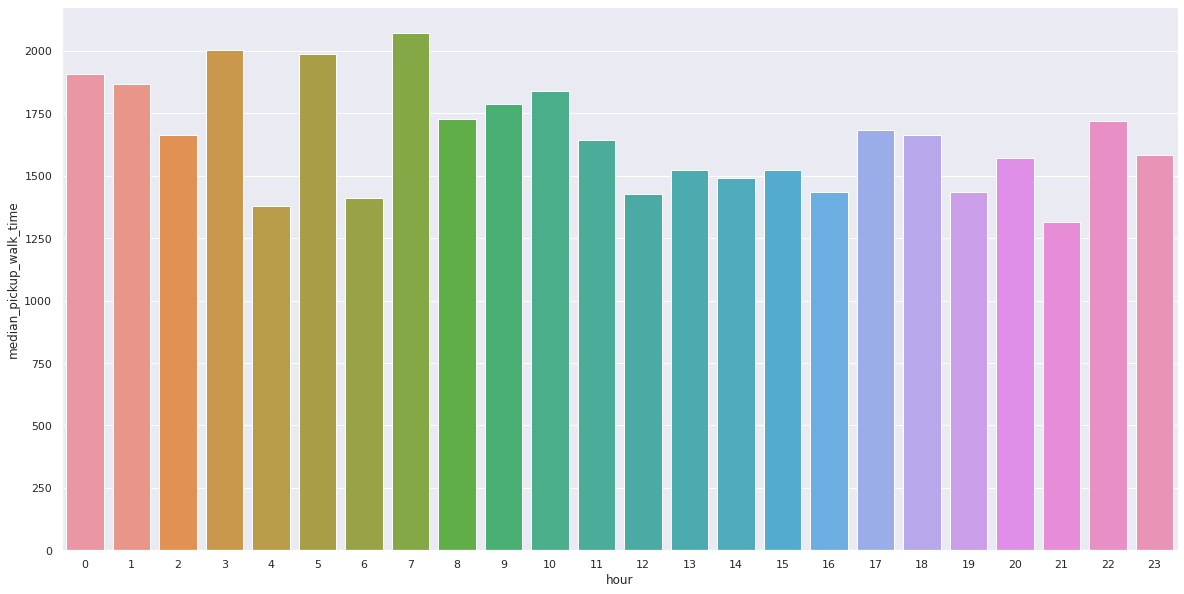

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=c, x='hour', y='median_pickup_walk_time', ci=None, ax=ax)

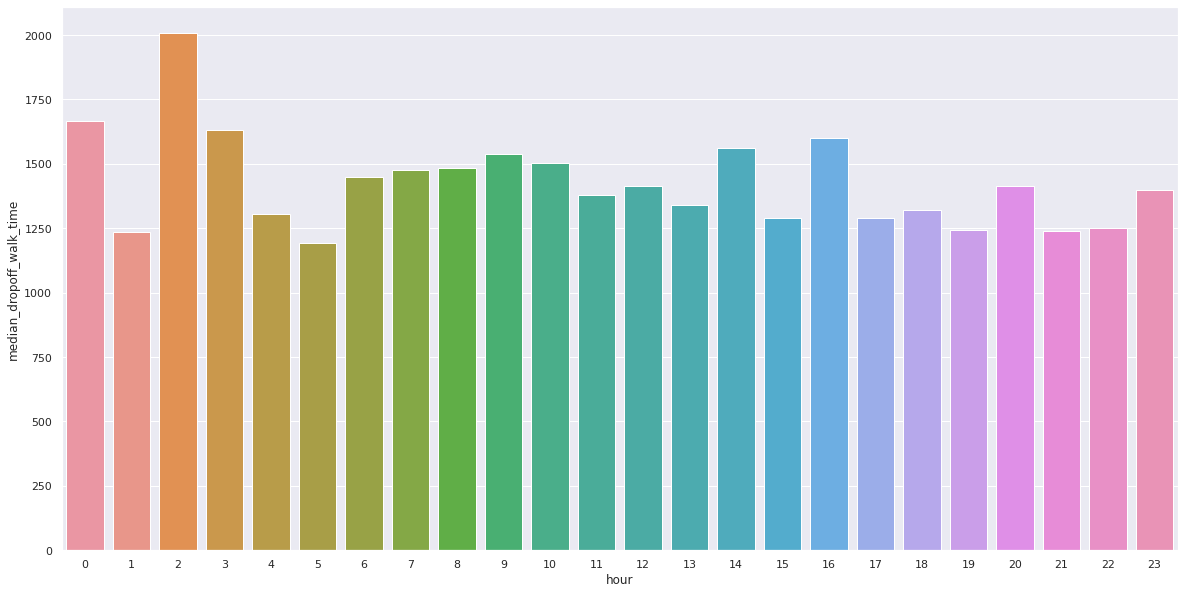

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=c, x='hour', y='median_dropoff_walk_time', ci=None, ax=ax)

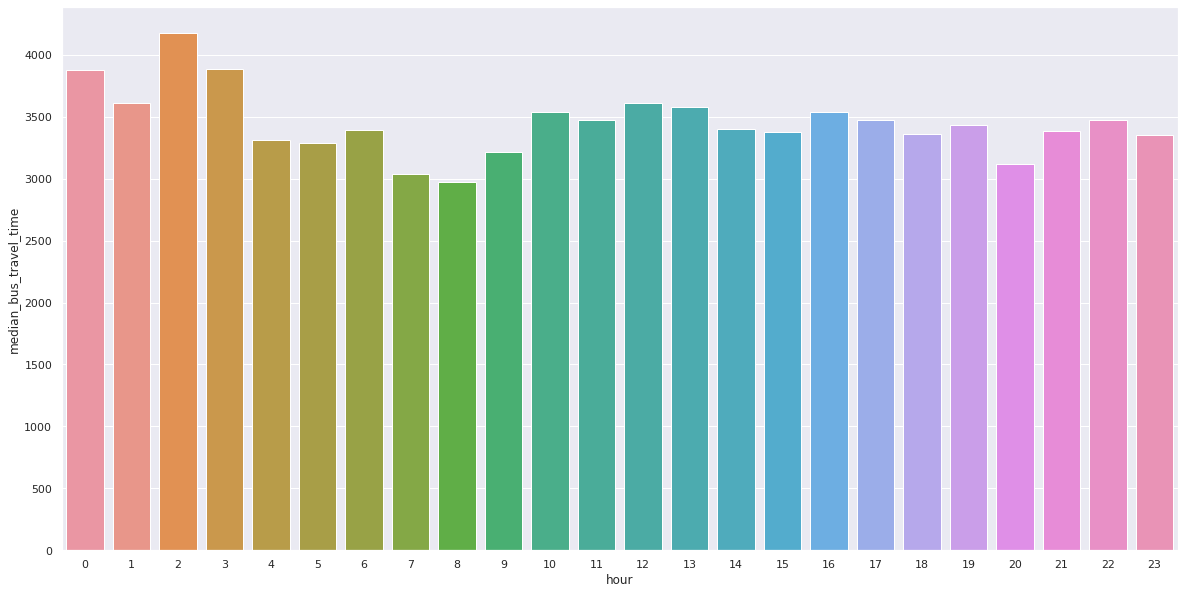

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=c, x='hour', y='median_bus_travel_time', ci=None, ax=ax)

Pada grafik di atas terlihat bahwa tidak ada pola khusus yang terbentuk antara kolom median_pickup_walk_time, median_dropoff_walk_time, median_bus_travel_time. Semua berjalan normal pada jam berapapun.

In [ ]:
d = df_total2.groupby([pd.Grouper(key='search_time', freq='H'), 'hour_search', 'day_search']).agg(search_count=('search_id', 'count'),
          high_demand=('high_demand_val', 'sum'),
         median_pickup_walk_time=('median_pickup_walk_time','mean'),
         median_dropoff_walk_time=('median_dropoff_walk_time','mean'),
        median_bus_travel_time=('median_bus_travel_time', 'mean'))
hour = []
day = []
user = []
for value in d.index.get_level_values(1):
  hour.append(value)
for value in d.index.get_level_values(2):
  day.append(value)

d['hour'] = hour
d['day'] = day
d.head()

,,,search_count,high_demand,median_pickup_walk_time,median_dropoff_walk_time,median_bus_travel_time,hour,day
search_time,hour_search,day_search,,,,,,,
2019-10-14 03:00:00+00:00,3,Monday,12,0,1380.000000,1890.000000,3303.000000,3,Monday
2019-10-14 04:00:00+00:00,4,Monday,32,140,708.750000,5790.000000,2034.781250,4,Monday
2019-10-14 07:00:00+00:00,7,Monday,12,36,10620.000000,120.000000,1408.000000,7,Monday
2019-10-14 08:00:00+00:00,8,Monday,82,42,1576.097561,693.658537,1647.317073,8,Monday
2019-10-14 09:00:00+00:00,9,Monday,67,38,620.597015,1230.447761,2378.298507,9,Monday


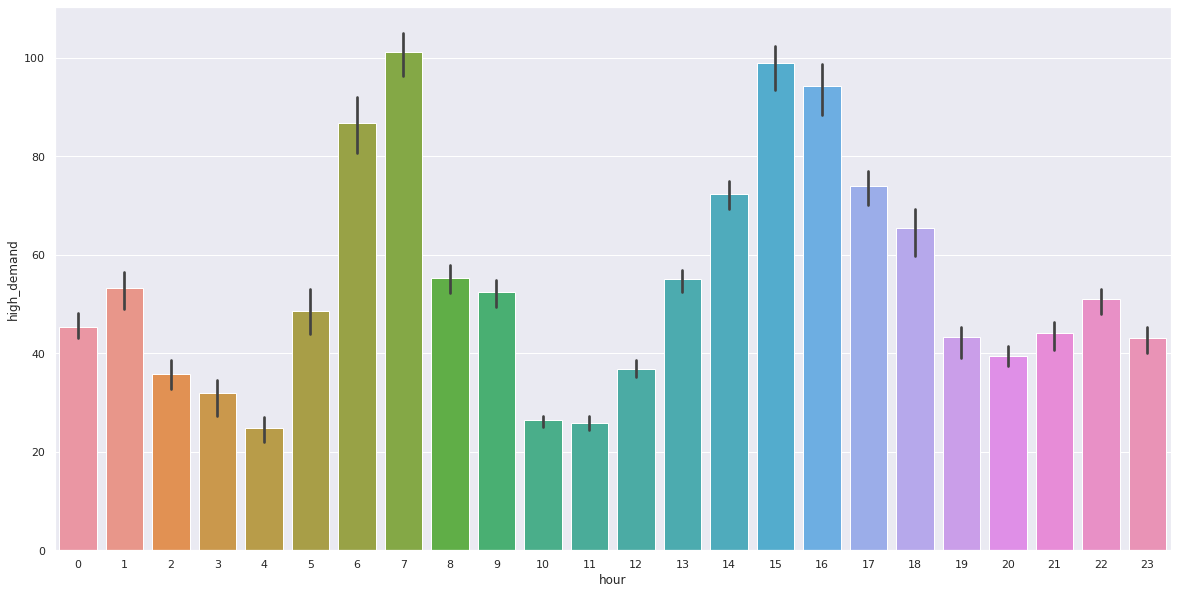

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=d, x='hour', y='high_demand', ci=25, ax=ax)

Grafik di atas menunjukkan jumlah kursi kosong pada tiap jamnya.
* Pada jam 7 sampai jam 10 terjadi penurunan pada grafik. Hal ini menunjukkan menurunnya jumlah kursi kosong pada jam tersebut. Berarti pada jam 7 sampai jam 10 merupakan waktu waktu yang sibuk/ramai. Pada jam 7 sampai jam 10 merupakan waktu waktu berangkat jam kerja.
* Mulai jam 3 sore sampai 8 malam terjadi penurunan pada grafik. Terjadi penurunan pada grafik yang berarti menurunnya jumlah kursi kosong pada jam tersebut. Hal ini bisa diasumsikan bahwa pada jam 3 jam sore sampai jam 8 malam merupakan waktu pulang kerja.

In [ ]:
df_total2.columns

Index(['user_id', 'yr_wk', 'new_segment_tag', 'session_id', 'search_id',
       'search_city', 'search_time', 'num_of_results', 'is_result',
       'median_pickup_walk_time', 'median_dropoff_walk_time',
       'median_bus_travel_time', 'high_demand_val', 'user_device_os',
       'user_device_app_version', 'search_session_id', 'booking_id',
       'booking_timestamp', 'hour_search', 'hour_books', 'day_search',
       'day_books'],
      dtype='object')

In [ ]:
df_total2.columns

Index(['user_id', 'yr_wk', 'new_segment_tag', 'session_id', 'search_id',
       'search_city', 'search_time', 'num_of_results', 'is_result',
       'median_pickup_walk_time', 'median_dropoff_walk_time',
       'median_bus_travel_time', 'high_demand_val', 'user_device_os',
       'user_device_app_version', 'search_session_id', 'booking_id',
       'booking_timestamp', 'hour_search', 'hour_books', 'day_search',
       'day_books'],
      dtype='object')

In [ ]:
# hanya ada satu search_city sehingga tidak terlalu membantu dalam visualisasi data
# Dan rute perjalanan sudah ditetapkan sehingga tidak bisa melihat rute mana yang paling ramai
df_total2.search_city.unique()

array(['New York'], dtype=object)

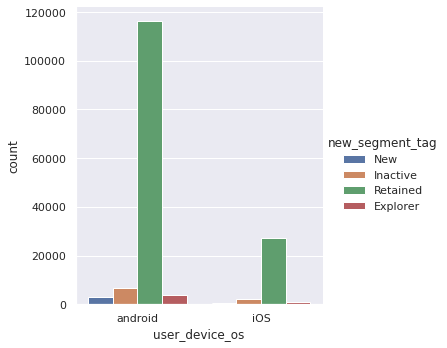

In [ ]:
sns.catplot(x="user_device_os", hue="new_segment_tag", kind="count",
            data=df_total2)

Ternyata user pada Apps Bus Ride paling banyak menggunakan device android. Terlebih user tersebut merupakan user retained.

In [ ]:
df_total2.to_csv('df_total_fix.csv')

## REKOMENDASI

## KESIMPULAN - Create the story



1.   Perusahaan bisa memberikan promo yang dibagi menjadi 3 jenis, yaitu
> * Promo untuk user baru, dimana user baru bisa mendapatkan potongan harga 
> * Promo untuk user retained agar tetap menggunakan apps ini. Semakin banyak user retained melakukan pemesanan, maka bisa mendapatkan diskon yang lebih menggiurkan.
> * Promo untuk user inactive yang telah inactive beberapa minggu sehingga ketika user kembali bisa tertarik untuk melakukan pemesanan
2.   Mengurangi jumlah armada pada hari jumat.<br> Berdasarkan data di atas, hari jumat selalu mengalami penurunan entah itu dalam jumlah pencarian maupun pemesanan. Dengan mengurangi jumlah armada pada hari jumat bisa menekan biaya operasi.
3.   Menambah Armada pada jam tertentu. <br>
Pada jam berangkat kerja mulai dari jam 7 sampai 10 pagi dan jam pulang kerja dari jam 3 sore sampai jam 8 malam. Terjadi peningkatan jumlah pencarian, jumlah pemesanan dan juga menurunnya jumlah kursi kosong. Sehingga, diperlukan penambahan armada pada jam tersebut untuk memenuhi permintaan.

